# 1. Environment and project setup

### Section 1.1: Importing Libraries and GPU Configuration
This block imports necessary libraries for data processing (`os`, `numpy`, `librosa`) and model building using TensorFlow/Keras. It also verifies GPU availability to ensure the system leverages hardware acceleration.

In [1]:
# Import libraries
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
import random

# Ensure TensorFlow uses GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

2025-01-19 23:57:02.884583: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 23:57:03.200734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  0
GPUs Available: []


### Section 1.2: Dataset Path Initialization
Defines paths for the ASVspoof2019 Logical Access dataset (training set, test set, and a test set with different distribution) along with their corresponding protocol files. This setup ensures structured access to audio and label data for preprocessing and model training.

In [2]:
# Dataset paths
DATASET_PATH = "/mnt/c/DF/LA/"
DATASET_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_train/flac")  # Path to training audio files
DATASET_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_dev/flac")     # Path to validation audio files
DATASET_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_eval/flac")   # Path to test audio files

# Label files contain the protocol for bonafide/spoof labels for each audio file
LABELS_TRAIN = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt")
LABELS_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.dev.trl.txt")
LABELS_UNSEEN_TEST = os.path.join(DATASET_PATH, "ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt")

# Print paths to verify correctness
print("Train Dataset Path:", DATASET_TRAIN)
print("Labels Train Path:", LABELS_TRAIN)

Train Dataset Path: /mnt/c/DF/LA/ASVspoof2019_LA_train/flac
Labels Train Path: /mnt/c/DF/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt


### Section 1.3: Audio Preprocessing Configuration
Defines key parameters for audio preprocessing:
- **Sample rate:** 16 kHz to ensure uniformity.
- **Clip duration:** 5 seconds to standardize input length.
- **Mel bins:** 128 for Mel spectrogram generation.
The number of classes is set to 2 for binary classification (bonafide vs. spoof).

In [3]:
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 1  # Duration of audio clips in seconds
N_FFT = 2048  # Window size for Short-Time Fourier Transform. 512 samples corresponds to ~32 ms at 16 kHz.
HOP_LENGTH = 512 # Step size for the STFT windows. A value of 256 (~50% overlap) ensures good temporal resolution.
MAX_LEN = 45000  # The target length of audio files in samples (2 seconds at 16 kHz = 32000 samples).
RANDOM_STATE = 2159081 # For reproducibility

random.seed(RANDOM_STATE)  # For reproducibility

# 2. Loading and balancing dataset labels
### Section 2.1: Loading Labels from Protocol Files
This block defines and uses a function to load labels from ASVspoof protocol files. Labels are mapped to filenames and splitted into two arrays for better reuse.

In [4]:
# Define a function to load labels and split filenames from the protocol file
def load_labels(file_path):
    bonafide_files = []
    spoof_files = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Example protocol line: <file_id> <label>
            file_id, filename, label = parts[0], parts[1], parts[-1]
            if label == "bonafide":
                bonafide_files.append(filename)
            else:
                spoof_files.append(filename)
    return np.array(bonafide_files), np.array(spoof_files)

# Load training labels
train_bonafide_filenames, train_spoof_filenames = load_labels(LABELS_TRAIN)
test_bonafide_filenames, test_spoof_filenames = load_labels(LABELS_TEST)

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))

Number of training bonafide samples: 2580
Number of training spoof samples: 22800
Number of test bonafide samples: 2548
Number of test spoof samples: 22296


### Section 2.2: Reduce data for test speed

In [5]:
def shuffle_and_trim_list(input_list, n=10000):
    # List and shuffle
    random.shuffle(input_list)

    return input_list[:n]

# ATTENTION: Dataset limiting --------------------------------
train_bonafide_filenames = shuffle_and_trim_list(train_bonafide_filenames, n=250)
train_spoof_filenames = shuffle_and_trim_list(train_spoof_filenames, n=200)
test_bonafide_filenames = shuffle_and_trim_list(test_bonafide_filenames, n=200)
test_spoof_filenames = shuffle_and_trim_list(test_spoof_filenames, n=200)
# ATTENTION: Dataset limiting --------------------------------

# Print some examples
print("Number of training bonafide samples:", len(train_bonafide_filenames))
print("Number of training spoof samples:", len(train_spoof_filenames))
print("Number of test bonafide samples:", len(test_bonafide_filenames))
print("Number of test spoof samples:", len(test_spoof_filenames))

Number of training bonafide samples: 250
Number of training spoof samples: 200
Number of test bonafide samples: 200
Number of test spoof samples: 200


# 3. Files loading and Preprocessing
### Section 3.1: Loading Dataset Files and STFT Conversion
- A function `load_dataset_files` is defined to:
  - Load audio files.
  - Convert them to STFT format using `librosa`.
- A progress bar (`tqdm`) is used to visualize file loading operations.
- The function processes and loads the training, validation, and testing datasets, ensuring the data is ready for model input.

In [6]:
import os
import librosa
import numpy as np
from tqdm import tqdm

# Function to load and preprocess audio files, ensuring all are standardized to the same length
def load_audio_files(dataset_path, file_list, sr=16000, max_len=32000):
    """
    Load and preprocess audio files from a specified dataset path.
    Ensures all audio signals are the same length by applying zero padding or trimming.

    Args:
        dataset_path (str): Path to the directory containing the audio files.
        file_list (list): List of file names (without extensions) to load.
        sr (int): Sampling rate for audio loading. Default is 16000.
        max_len (int): Target length for each audio signal (in samples).

    Returns:
        np.array: Array containing processed audio signals, all standardized to the same length.
    """
    audio_data = []
    for filename in tqdm(file_list, desc="Loading audio files"):
        file_path = os.path.join(dataset_path, f"{filename}.flac")
        try:
            # Load the audio file with the specified sampling rate
            audio, _ = librosa.load(file_path, sr=sr, duration=max_len / sr)

            # Ensure the audio length matches the target length (padding or trimming as needed)
            audio = librosa.util.fix_length(audio, size=max_len)

            # Add the processed audio signal to the list
            audio_data.append(audio)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    # Return all processed audio signals as a numpy array
    return np.array(audio_data)

# Load bonafide and spoof samples for training, testing, and unseen testing datasets

# Training data for bonafide samples
audio_data_train_bonafide = load_audio_files(DATASET_TRAIN, train_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Training data for spoof samples
audio_data_train_spoof = load_audio_files(DATASET_TRAIN, train_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Test data for bonafide samples
audio_data_test_bonafide = load_audio_files(DATASET_TEST, test_bonafide_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)
# Test data for spoof samples
audio_data_test_spoof = load_audio_files(DATASET_TEST, test_spoof_filenames, sr=SAMPLE_RATE, max_len=MAX_LEN)

Loading audio files: 100%|███████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 219.63it/s]


### Section 3.2: Extract STFT features

In [7]:
# Function to extract Short-Time Fourier Transform (STFT) features from audio files
def compute_stft(audio_files, n_fft=2048, hop_length=512):
    """
    Extract Short-Time Fourier Transform (STFT) features from a list of audio signals.

    Args:
        audio_files (list): List of audio signals.
        n_fft (int): Number of FFT components. Default is 2048.
        hop_length (int): Number of samples between successive frames. Default is 512.

    Returns:
        np.array: Array containing the magnitude spectrograms for each audio signal.
    """
    stft_features = []  # Initialize a list to store STFT features for each audio file.
    
    for audio in tqdm(audio_files, desc="Extracting STFT features"):
        # Compute the Short-Time Fourier Transform (STFT) of the audio signal.
        stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length)
        
        # Compute the magnitude spectrogram by taking the absolute value of the STFT result.
        spectrogram = np.abs(stft)
        
        # Append the magnitude spectrogram to the features list.
        stft_features.append(spectrogram)
    
    # Convert the list of spectrograms to a NumPy array and return it.
    return np.array(stft_features)

# Compute STFT for all samples
# Bonafide training samples
stft_data_train_bonafide = compute_stft(audio_data_train_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Spoof training samples
stft_data_train_spoof = compute_stft(audio_data_train_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Bonafide test samples
stft_data_test_bonafide = compute_stft(audio_data_test_bonafide, n_fft=N_FFT, hop_length=HOP_LENGTH)
# Spoof test samples
stft_data_test_spoof = compute_stft(audio_data_test_spoof, n_fft=N_FFT, hop_length=HOP_LENGTH)

Extracting STFT features: 100%|██████████████████████████████████████████████████████| 200/200 [00:00<00:00, 916.81it/s]


### Section 3.3: STFT data Visualization & Analysys

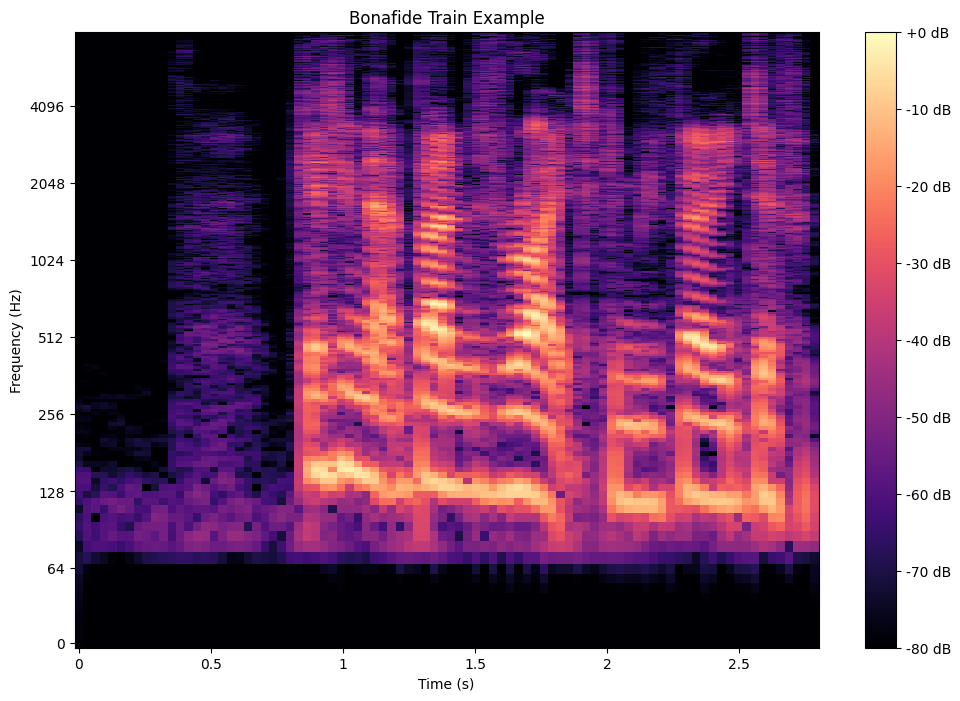

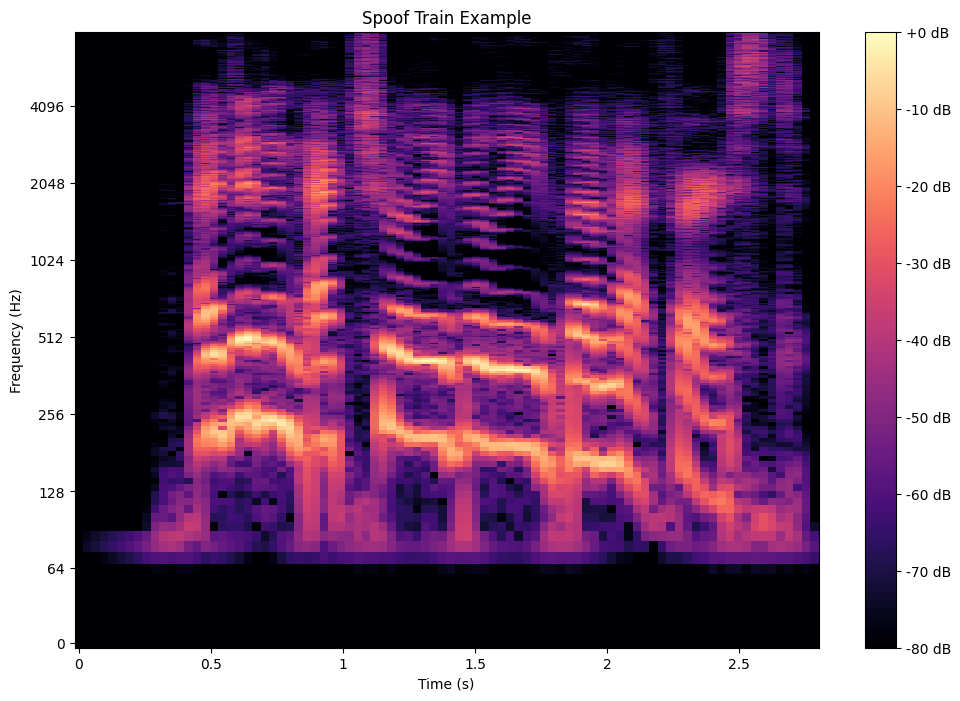

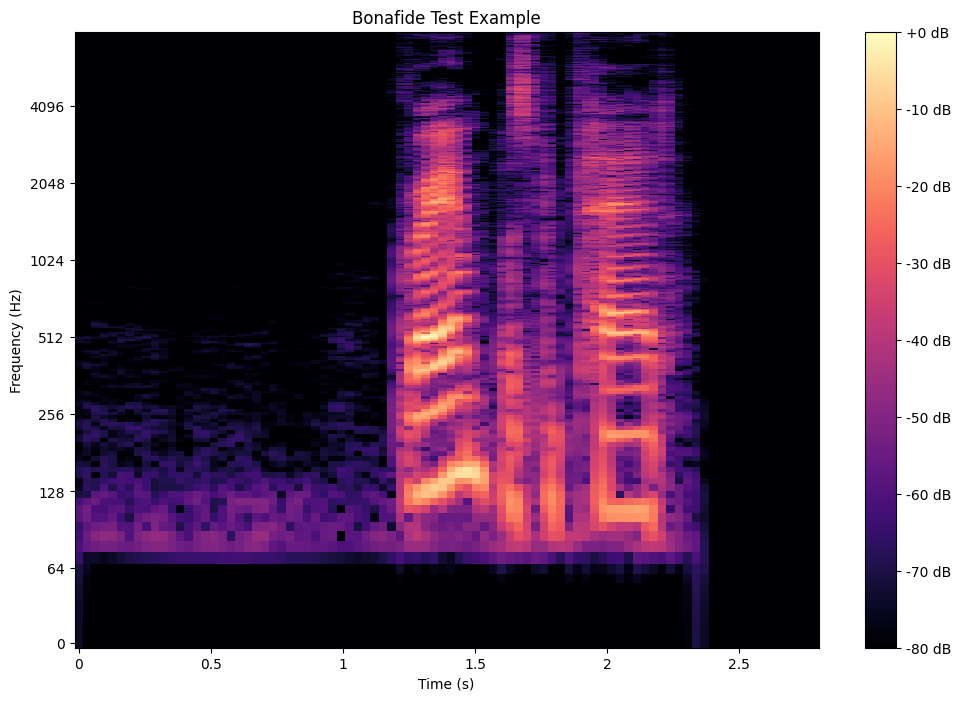

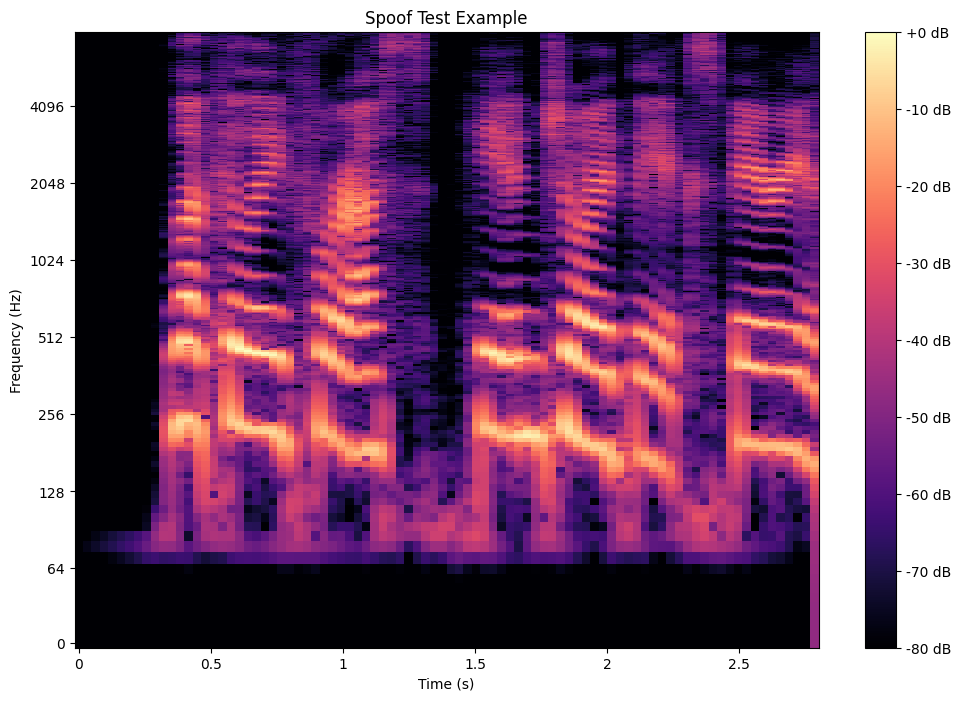

In [8]:
import random
import matplotlib.pyplot as plt

# Function to compute and visualize the spectrogram of an audio file
def plot_spectrogram(spectrogram, title, sr=16000, hop_length=512):
    """
    Visualize the spectrogram of an audio signal.

    Args:
        spectrogram (np.array): Magnitude spectrogram to visualize.
        title (str): Title of the plot.
        sr (int): Sampling rate of the audio signal. Default is 16000.
        hop_length (int): Hop length used in the STFT. Default is 512.
    """
    # Set up the figure for plotting
    plt.figure(figsize=(12, 8))
    
    # Display the spectrogram, converting amplitude values to decibels (dB)
    librosa.display.specshow(
        librosa.amplitude_to_db(spectrogram, ref=np.max),  # Convert amplitude to dB scale
        sr=sr,  # Sampling rate of the audio signal
        hop_length=hop_length,  # Hop length used in the STFT
        x_axis='time',  # Display time on the x-axis
        y_axis='log'    # Use a logarithmic scale for the frequency axis
    )
    
    # Add a color bar to indicate the dB scale
    plt.colorbar(format='%+2.0f dB')
    
    # Add plot title and axis labels
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    
    # Display the plot
    plt.show()

# Generate a random integer between 0 and 100 (inclusive)
random_number = random.randint(0, 100)

# Plot some examples
plot_spectrogram(stft_data_train_bonafide[random_number], "Bonafide Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_train_spoof[random_number], "Spoof Train Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_bonafide[random_number], "Bonafide Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plot_spectrogram(stft_data_test_spoof[random_number], "Spoof Test Example", sr=SAMPLE_RATE, hop_length=HOP_LENGTH)

# 4. Feature reduction: Autoencoder and Latent Space
### Section 4.1: Transpose the data to adapt it to autoencoder input

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca_with_variance(stft_data, variance_ratio=0.95, pca_model=None, fit=True):
    """
    Applies PCA for dimensionality reduction while retaining a specified variance ratio.

    Args:
        stft_data (np.array): Input data for PCA. Shape should be (samples, time_steps, n_stft).
        variance_ratio (float): Percentage of variance to retain in PCA (default=0.95).
        pca_model: Pre-trained PCA model (default=None). If provided, it skips fitting.
        fit (bool): Whether to fit PCA on the provided data (default=True).

    Returns:
        reduced_data (np.array): PCA-transformed data.
        pca_model: Trained PCA model.
    """
    # Reshape the data to 2D for PCA
    original_shape = stft_data.shape
    reshaped_data = stft_data.reshape(-1, original_shape[-1])  # Shape: (samples * time_steps, n_stft)

    # Standardize the data
    scaler = StandardScaler()
    reshaped_data = scaler.fit_transform(reshaped_data)

    if fit:  # Fit PCA model
        pca_model = PCA(n_components=variance_ratio, svd_solver='full')  # Retain specified variance ratio
        pca_model.fit(reshaped_data)

    # Transform data with PCA
    reduced_data = pca_model.transform(reshaped_data)
    reduced_data = reduced_data.reshape(original_shape[0], original_shape[1], -1)  # Restore 3D shape
    print(f"PCA reduced shape: {reduced_data.shape}, retained variance: {sum(pca_model.explained_variance_ratio_):.2f}")
    return reduced_data, pca_model

# Applicazione ai dati
variance_ratio_to_keep = 0.90  # Retain 90% of the variance
pca_model = None

stft_data_train_bonafide, pca_model = apply_pca_with_variance(stft_data_train_bonafide, variance_ratio=variance_ratio_to_keep, fit=True)
stft_data_train_spoof, _ = apply_pca_with_variance(stft_data_train_spoof, variance_ratio=variance_ratio_to_keep, pca_model=pca_model, fit=False)
stft_data_test_bonafide, _ = apply_pca_with_variance(stft_data_test_bonafide, variance_ratio=variance_ratio_to_keep, pca_model=pca_model, fit=False)
stft_data_test_spoof, _ = apply_pca_with_variance(stft_data_test_spoof, variance_ratio=variance_ratio_to_keep, pca_model=pca_model, fit=False)

# Salva il modello PCA
import joblib
pca_model_filename = "optimized_pca_model.pkl"
joblib.dump(pca_model, pca_model_filename)
print(f"PCA model saved to '{pca_model_filename}'.")

PCA reduced shape: (250, 1025, 32), retained variance: 0.90
PCA reduced shape: (200, 1025, 32), retained variance: 0.90
PCA reduced shape: (200, 1025, 32), retained variance: 0.90
PCA reduced shape: (200, 1025, 32), retained variance: 0.90
PCA model saved to 'optimized_pca_model.pkl'.


# 5. One-Class SVM
### Section 5.1: Rescale latent data

### Section 5.2 Define the model and the labels

In [12]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Load the PCA-transformed training data
X_one = stft_data_train_bonafide.reshape(stft_data_train_bonafide.shape[0], -1)  # Flatten to 2D array for SVM
y_one = np.ones(X_one.shape[0])  # Assign all training samples a label of 1 (normal/bonafide)

# Initialize the One-Class SVM model
ocsvm = OneClassSVM()  # One-Class SVM for anomaly detection

# Define the hyperparameter grid for grid search
param_grid = {
    'kernel': ['rbf', 'poly'],  # Kernel types for the SVM
    'gamma': ['scale', 'auto', 0.1, 0.5]  # Kernel coefficient for RBF/poly kernels
}

### Section 5.3: Fit the model with paramgrid

In [ ]:
# Perform Grid Search with Cross-Validation to optimize hyperparameters
grid_search = GridSearchCV(
    ocsvm,                   # One-Class SVM model to optimize
    param_grid,              # Dictionary of hyperparameter options
    cv=5,                    # Number of cross-validation folds
    n_jobs=-1,               # Use all available CPU cores for parallel processing
    scoring='accuracy'       # Scoring metric to evaluate model performance
)

# Fit the grid search model using the PCA-transformed training data
grid_search.fit(X_one, y_one)

# Retrieve and display the best hyperparameters found during the grid search
best_params = grid_search.best_params_  # Best combination of hyperparameters
print("Best parameters found:", best_params)

# Retrieve and display the mean cross-validation score for the best hyperparameters
best_score = grid_search.best_score_  # Mean CV score for the best model
print(f"Mean cross-validation score with best parameters: {best_score:.4f}")

### Section 5.4: Do testing

In [ ]:
# Use the best model to predict test data
X_test_bonafide = stft_data_test_bonafide.reshape(stft_data_test_bonafide.shape[0], -1)  # Flatten for testing
X_test_spoof = stft_data_test_spoof.reshape(stft_data_test_spoof.shape[0], -1)  # Flatten for testing

# Combine test datasets
X_test = np.concatenate([X_test_bonafide, X_test_spoof], axis=0)
y_test = np.concatenate([np.ones(X_test_bonafide.shape[0]), -np.ones(X_test_spoof.shape[0])])  # 1 for bonafide, -1 for spoof

# Predict the labels of the test dataset using the best One-Class SVM model
best_model = grid_search.best_estimator_  # Get the best model from grid search
y_pred = best_model.predict(X_test)

### Section 5.5: Show results

In [ ]:
# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Spoof Sample", "Bonafide Sample"]))

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Spoof Sample", "Bonafide Sample"])
plt.title("Confusion Matrix")
plt.show()

# Calculate and plot the ROC curve
y_scores = best_model.decision_function(X_test)
roc_auc = roc_auc_score((y_test == 1).astype(int), y_scores)
fpr, tpr, thresholds = roc_curve((y_test == 1).astype(int), y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - One-Class SVM")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"ROC-AUC Score: {roc_auc:.4f}")
